W tym pliku zawarta jest niemal pełna praca wykonana w ramach projektu.

In [42]:
library(randomForest)
library(glmnet)
library(caret)

In [43]:
test = read.table("zbior_testowy.txt",header=TRUE, sep=";")

In [44]:
train = read.table("zbior_uczacy.txt",header=TRUE,sep=";")

In [45]:
head(train,5) #sprawdzenie wczytanego zbioru treningowego

y,A1,B1,C1,D1,E1,F1,G1,H1,I1,⋯,O2,P2,Q2,R2,S2,T2,U2,V2,W2,X2
klasa -,A,B,A,7.2,B,B,17.3,96.8,8.9,⋯,B,C,A,B,81.4,53.9,60.9,51.0,42.1,39.1
klasa -,B,A,B,99.6,D,C,26.2,64.1,17.8,⋯,A,A,A,B,37.5,27.5,60.9,80.1,45.6,21.6
klasa +,B,A,B,79.7,C,D,2.5,47.2,62.8,⋯,B,B,A,B,99.9,7.8,43.8,68.7,38.4,24.1
klasa +,B,B,B,86.3,C,C,25.8,48.1,80.6,⋯,A,D,B,B,77.8,90.7,55.5,4.5,65.2,78.9
klasa +,A,A,A,67.6,C,C,67.3,41.0,10.9,⋯,B,C,B,A,37.4,40.5,18.3,41.8,71.5,13.1


## Preprocessing

In [46]:
#obrobka danych - usuwanie zmiennych kategorycznych, zamiana na dummies
dummies = dummyVars(y ~ ., data = train)
train_x = predict(dummies, newdata = train)
#etykiety jako wektor logiczny - TRUE==klasa +
train_y= (train$y=='klasa +')

Warning message in model.frame.default(Terms, newdata, na.action = na.action, xlev = object$lvls):
“variable 'y' is not a factor”

In [47]:
head(train_x)

,A1.A,A1.B,B1.A,B1.B,C1.A,C1.B,D1,E1.A,E1.B,E1.C,⋯,Q2.A,Q2.B,R2.A,R2.B,S2,T2,U2,V2,W2,X2
1,1,0,0,1,1,0,7.2,0,1,0,⋯,1,0,0,1,81.4,53.9,60.9,51.0,42.1,39.1
2,0,1,1,0,0,1,99.6,0,0,0,⋯,1,0,0,1,37.5,27.5,60.9,80.1,45.6,21.6
3,0,1,1,0,0,1,79.7,0,0,1,⋯,1,0,0,1,99.9,7.8,43.8,68.7,38.4,24.1
4,0,1,0,1,0,1,86.3,0,0,1,⋯,0,1,0,1,77.8,90.7,55.5,4.5,65.2,78.9
5,1,0,1,0,1,0,67.6,0,0,1,⋯,0,1,1,0,37.4,40.5,18.3,41.8,71.5,13.1
6,1,0,0,1,0,1,99.2,0,1,0,⋯,1,0,0,1,17.6,90.0,82.9,6.8,31.6,68.2


In [48]:
#near zero variance predictors
nzv = nearZeroVar(train_x)

In [49]:
#żadne predyktory nie są stałe - nie trzeba żadnych wyrzucać
length(nzv)

[1] 0

In [50]:
#usuwanie predyktorów skorelowanych
cr = cor(train_x)

In [51]:
correlated = findCorrelation(cr, cutoff = .75)

In [52]:
#tutaj akurat oczywiste co wyszlo, rozbijanie factorow z 2 levelami na dummies daje ich korelację -1.
colnames(train_x)[correlated]
#także należy to usunąć:
train_x = train_x[,-correlated]

[1] "A1.A" "I2.A" "Y1.A" "R2.A" "J2.A" "C1.A" "R1.A" "Q2.A" "O2.A" "B1.A"

In [53]:
#jeszcze jedno sprawdzenie z mniejszym cutoff
cr = cor(train_x)
correlated = findCorrelation(cr, cutoff = .5)
length(correlated)

[1] 0

In [54]:
#jest ok. zostają zależności liniowe:
comboInfo = findLinearCombos(train_x)
comboInfo

$linearCombos
$linearCombos[[1]]
[1] 12  5  6  7  8  9 10 11

$linearCombos[[2]]
[1] 20  5  6  7  8 17 18 19

$linearCombos[[3]]
[1] 24  5  6  7  8 21 22 23

$linearCombos[[4]]
[1] 31  5  6  7  8 28 29 30

$linearCombos[[5]]
[1] 38  5  6  7  8 35 36 37

$linearCombos[[6]]
[1] 47  5  6  7  8 44 45 46

$linearCombos[[7]]
[1] 53  5  6  7  8 50 51 52

$linearCombos[[8]]
[1] 57  5  6  7  8 54 55 56

$linearCombos[[9]]
[1] 72  5  6  7  8 69 70 71


$remove
[1] 12 20 24 31 38 47 53 57 72

In [55]:
comboInfo$remove

[1] 12 20 24 31 38 47 53 57 72

In [56]:
#mądry pakiet znalazł mi kilka predyktorów do usunięcia
train_x = train_x[,-comboInfo$remove]
#a teraz?
comboInfo = findLinearCombos(train_x)
comboInfo

$linearCombos
list()

$remove
NULL


In [58]:
#zapamiętuję to na później:
(preselected_coefs = colnames(train_x))

[1] "A1.B" "B1.B" "C1.B" "D1"   "E1.A" "E1.B" "E1.C" "E1.D" "F1.A" "F1.B"
[11] "F1.C" "G1"   "H1"   "I1"   "J1"   "K1.A" "K1.B" "K1.C" "L1.A" "L1.B"
[21] "L1.C" "M1"   "N1"   "O1"   "P1.A" "P1.B" "P1.C" "Q1"   "R1.B" "S1"  
[31] "T1.A" "T1.B" "T1.C" "U1"   "V1"   "W1"   "X1"   "Y1.B" "Z1.A" "Z1.B"
[41] "Z1.C" "A2"   "B2"   "C2.A" "C2.B" "C2.C" "D2.A" "D2.B" "D2.C" "E2"  
[51] "F2"   "G2"   "H2"   "I2.B" "J2.B" "K2"   "L2"   "M2"   "N2"   "O2.B"
[61] "P2.A" "P2.B" "P2.C" "Q2.B" "R2.B" "S2"   "T2"   "U2"   "V2"   "W2"  
[71] "X2"

# Regresja logistyczna

### Selekcja zmiennych 

In [19]:
#nieistotne zmienne
s = summary(glm(train_y~train_x))
s


Call:
glm(formula = train_y ~ train_x)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-0.99560  -0.44381   0.05306   0.43328   1.08655  

Coefficients: (1 not defined because of singularities)
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  6.095e-01  2.412e-02  25.269  < 2e-16 ***
train_xA1.B  8.892e-03  4.205e-03   2.115  0.03444 *  
train_xB1.B -1.048e-02  4.203e-03  -2.493  0.01267 *  
train_xC1.B -5.324e-03  4.204e-03  -1.266  0.20542    
train_xD1    7.229e-05  7.262e-05   0.995  0.31950    
train_xE1.A -1.871e-01  5.955e-03 -31.411  < 2e-16 ***
train_xE1.B  1.415e-03  5.952e-03   0.238  0.81207    
train_xE1.C  6.445e-03  5.978e-03   1.078  0.28104    
train_xE1.D         NA         NA      NA       NA    
train_xF1.A  2.413e-04  5.975e-03   0.040  0.96779    
train_xF1.B -1.541e-02  5.968e-03  -2.583  0.00979 ** 
train_xF1.C  2.907e-03  5.959e-03   0.488  0.62564    
train_xG1    1.642e-05  7.276e-05   0.226  0.82140    
train_xH1 

In [20]:
#(dość) istotne zmienne to:
#intercept, A1.B,B1.B,E1.A,F1.B,M1,P1.A,P1.B,Q1,W1,Z1.A,O2.B,P2.A,S2,T2,U2
important_coefs = c("A1.B","B1.B","E1.A","F1.B","M1","P1.A","P1.B","Q1","W1","Z1.A","O2.B",
                    "P2.A","S2","T2","U2")

Z ciekawości sprawdziłem jeszcze metodę varImp z pakietu caret, działa ona w analogiczny sposób jak summary, a jednocześnie nie trzeba przepisywać ręcznie wyników.

In [21]:
v = varImp(glm(train_y~train_x))

In [22]:
rownames(v)[v>1.78] #1.78 to pewna ważność, która daje rezultaty jak powyżej

[1] "train_xA1.B" "train_xB1.B" "train_xE1.A" "train_xF1.B" "train_xL1.B"
 [6] "train_xM1"   "train_xP1.A" "train_xP1.B" "train_xQ1"   "train_xT1.A"
[11] "train_xW1"   "train_xZ1.A" "train_xO2.B" "train_xP2.A" "train_xS2"  
[16] "train_xT2"   "train_xU2"

In [23]:
tdata = data.frame(y=train_y,train_x2[,important_coefs])

ERROR: Error in data.frame(y = train_y, train_x2[, important_coefs]): object 'train_x2' not found


In [24]:
#krokowa selekcja zmiennych, metoda backward bic
step(glm(y~.,tdata,family="binomial"), direction="backward", k =log(nrow(tdata)))

ERROR: Error in is.data.frame(data): object 'tdata' not found


In [25]:
#selekcja zredukowała nam zbiór atrybutów do ośmiu
selected_coefs = c("E1.A","F1.B","M1","Q1","W1","P2.A","T2","U2")
#uprzątam zbiory treningowe:
train_x2 = train_x[,selected_coefs]
train_data = data.frame(y=train_y,train_x2)

In [26]:
#funkcja dla wyznaczania skutecznosci modelu (fold)
nfold_glm = function (input_data,n){
    
    nchunk = nrow(input_data)/n
    results = numeric(n)
    
    for (i in 1:n){
        lower = (i-1)*nchunk+1
        upper = i*nchunk
        indices = lower:upper
        #kolumna 1 - etykieta
        tst_y = input_data[indices,1]
        tst_x = input_data[indices,-1]
        tr =  train_data[-indices,]
        g = glm(y~.,data=tr)
        predicted_y = predict(g, tst_x)
        #sprawdzam top 20% scores (jak w zadaniu)
        topindices = head(sort(predicted_y,decreasing=TRUE),nchunk/5)
        results[i] = (mean(input_data[names(topindices),1]))
    }
    return (results)
}

In [30]:
#10-fold, dane zwykle
results = nfold_glm(train_data,10)
results
#średnia z dziesięciu foldów
mean(results)

[1] 0.740 0.729 0.726 0.726 0.741 0.732 0.713 0.734 0.712 0.739

[1] 0.7292

In [42]:
#inne podejście
#standaryzacja danych:
preProcValues = preProcess(train_x2, method = c("scale"))
train_x3 = predict(preProcValues, train_x2)
train_data2 = data.frame(y=train_y,train_x3)

In [43]:
#10-fold, dane standaryzowane
results = nfold_glm(train_data2,10)
results
#średnia z dziesięciu foldów
mean(results)

[1] 0.721 0.726 0.704 0.717 0.737 0.703 0.696 0.722 0.691 0.730

[1] 0.7147

Standaryzacja nie polepsza wyników. Ogólnie, regresja logistyczna wydaje się dość kiepska.

By rozważyć wszystkie możliwości, sprawdzę jeszcze działanie lasso na danych.
Stosuję tutaj już ramkę z naistotniejszymi predyktorami.

In [44]:
cv.glmmod = cv.glmnet(train_x2, y=train_y)

In [45]:
cv.glmmod$lambda.1se
cv.glmmod$lambda.min

[1] 0.007570528

[1] 0.0004232539

Optymalna wartość członu od penalizacji dla regresji lasso (lambda) jest bardzo niska, spróbuję jednak zastosować model liniowy z regularyzacją lasso.

In [46]:
nfold_lasso = function (input_data, par_lambda,n){
    
    nchunk = nrow(input_data)/n
    results = numeric(n)
    
    for (i in 1:n){
        lower = (i-1)*nchunk+1
        upper = i*nchunk
        indices = lower:upper
        #kolumna 1 - etykieta
        tst_y = input_data[indices,1]
        names_tst_x = rownames(input_data[indices,-1])
        #trzeba zapamietac numery wierszy, bo ponizej są tracone:
        tst_x = as.matrix(input_data[indices,-1])
        tr_y =  input_data[-indices,1]
        tr_x =  as.matrix(input_data[-indices,-1])
        g = glmnet(x=tr_x,y=tr_y,lambda = par_lambda)
        predicted_y = predict(g, tst_x, type="response")
        names(predicted_y) = names_tst_x
        #20% najwyzszych scores ze zbioru - wedle zadania
        top2000indices = head(sort(predicted_y,decreasing=TRUE),nchunk/5)
        results[i] = mean(input_data[names(top2000indices),1])
    }
    
    return (results)
}

In [47]:
results = nfold_lasso(train_data,par_lambda = 0.00757052832207433, n=10)

results
mean(results)

[1] 0.740 0.730 0.732 0.727 0.733 0.729 0.708 0.732 0.709 0.747

[1] 0.7287

Wyniki niemal zbieżne z modelem bez regularyzacji. Jak podejrzewałem, nie ma tutaj potrzeby stosować regularyzacji. Można by w tym momencie zastanowić się nad zastosowaniem modelu z regularyzacją lasso dla pełnego modelu (t.j. da wszystkich predyktorów), jednakże nie widzę żadnego powodu, dla którego tego typu rozwiązanie spowodowałoby wytrenowanie lepszego modelu. W tym momencie najlepiej zakończyć tę część badania i przejść do lasów losowych.

# Lasy losowe

## Selekcja zmiennych

In [48]:
important_coefs

[1] "A1.B" "B1.B" "E1.A" "F1.B" "M1"   "P1.A" "P1.B" "Q1"   "W1"   "Z1.A"
[11] "O2.B" "P2.A" "S2"   "T2"   "U2"

Wracam do modelu ze zmiennymi preselected_coefs (train_y,train_x)

In [59]:
#trzeba znowu użyć factorów (klasa pos, klasa neg), bo problem jest ponownie problemem klasyfikacji
train_y2 = train$y

Trenowanie lasu losowego na zbiorze treningowym (na dziesięciu tysiącach obserwacji)

In [36]:
#trenuję model
train_x_short = train_x[1:10000,]
train_y_short = train_y2[1:10000]

rforest =randomForest(train_x_short, train_y_short)

Wybieram zmienne za pomocą funkcji varImp z pakietu caret.

In [37]:
v = varImp(rforest)

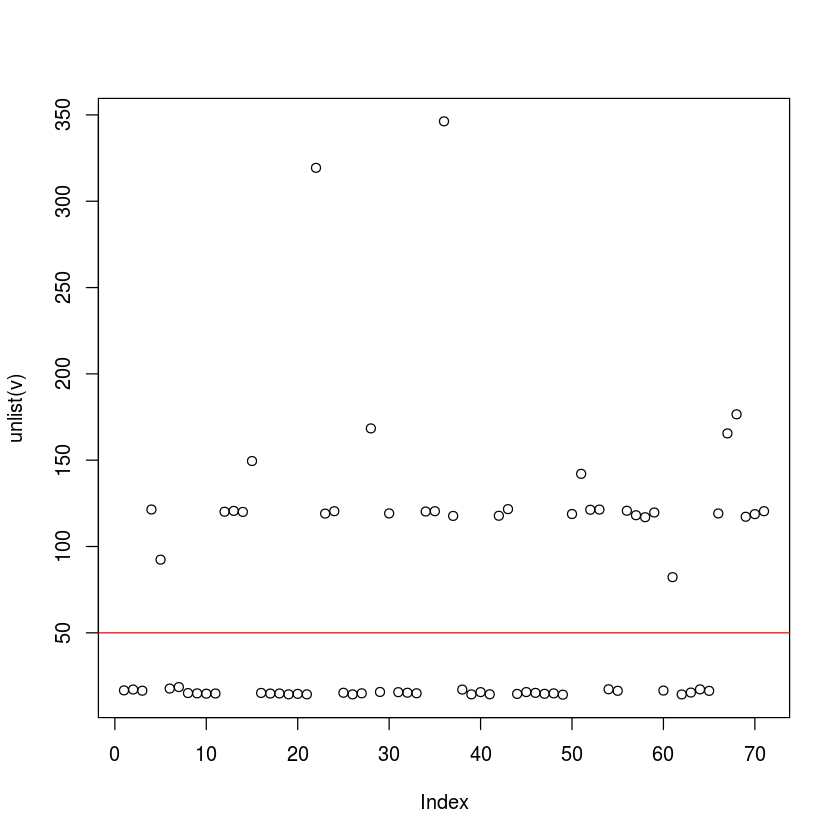

In [38]:
#wizualizuję wyniki ("ważności" poszczególnych predyktorów)
plot(unlist(v))
abline(50,0,col="red")

Z wykresu widoczne jest to, że niektóre predyktory są absolutnie niepotrzebne. Wobec tego wezmę jedynie te predyktory, które mają jakiekolwiek znaczenie.

In [39]:
pv = v[v>50]
names(pv) = rownames(v)[v>50]

Predyktory wybrane za pomocą powyższej metody:

In [40]:
length(pv)
names(pv)

[1] 32

[1] "D1"   "E1.A" "G1"   "H1"   "I1"   "J1"   "M1"   "N1"   "O1"   "Q1"  
[11] "S1"   "U1"   "V1"   "W1"   "X1"   "A2"   "B2"   "E2"   "F2"   "G2"  
[21] "H2"   "K2"   "L2"   "M2"   "N2"   "P2.A" "S2"   "T2"   "U2"   "V2"  
[31] "W2"   "X2"

Predyktory uzyskane z testów istotności zmiennych w modelu regresji były następujące:

In [42]:
length(important_coefs)
important_coefs

[1] 15

[1] "A1.B" "B1.B" "E1.A" "F1.B" "M1"   "P1.A" "P1.B" "Q1"   "W1"   "Z1.A"
[11] "O2.B" "P2.A" "S2"   "T2"   "U2"

Widać, że metody wybrały niemal kompletnie inne predyktory.

## Tuning parametrów dla lasu losowego

In [147]:
#pewna próbka zbioru treningowego
set.seed(997)
rnd = sample(1:length(train_y2),5000)
rfy = train_y2[rnd]
rfx = train_x[rnd,names(pv)] #wyselekcjonowane zmienne

Tuning parametru mtry:

mtry = 2  OOB error = 37.68% 
Searching left ...
mtry = 1 	OOB error = 38.78% 
-0.02919321 0.01 
Searching right ...
mtry = 4 	OOB error = 36.26% 
0.03768577 0.01 
mtry = 8 	OOB error = 34.08% 
0.06012135 0.01 
mtry = 16 	OOB error = 33.7% 
0.01115023 0.01 
mtry = 32 	OOB error = 34.8% 
-0.03264095 0.01 


,mtry,OOBError
1.OOB,1,0.3878
2.OOB,2,0.3768
4.OOB,4,0.3626
8.OOB,8,0.3408
16.OOB,16,0.3370
32.OOB,32,0.3480


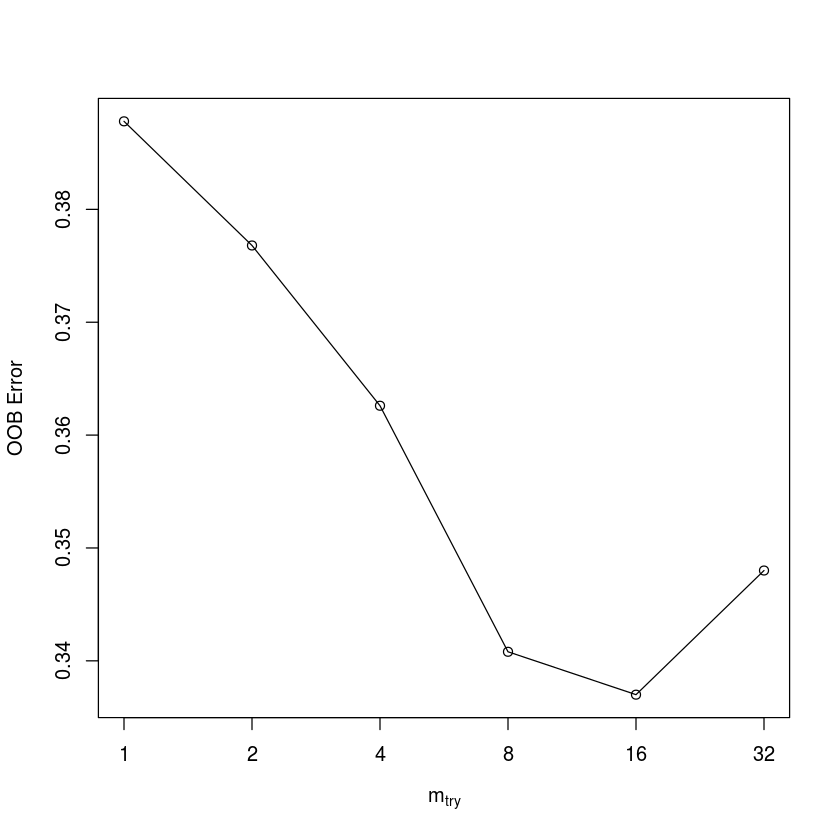

In [122]:
tuneRF(rfx, rfy, mtryStart=2, ntreeTry=50, stepFactor=2, improve=0.01,
trace=TRUE, plot=TRUE)

In [123]:
tuneFitControl <- trainControl(## 4-fold CV
                           method = "cv",
                           number = 4)

Tuning liczby drzew losowych (ntree)

In [145]:
#tutaj wywołuję funkcję dla kilku parametrów ntree, by zobaczyć zachowanie skuteczności:
dims = c(20,30,60,80,100,120,170,250,400)

rfFits = sapply(dims, function(x){ 
    model = train(rfx,rfy,
    method = "rf", 
    trControl = defaultFitControl,
    ntree = x,
    tuneGrid = data.frame(mtry=16)) #optymalne mtry
    return (model$results$Accuracy)
})

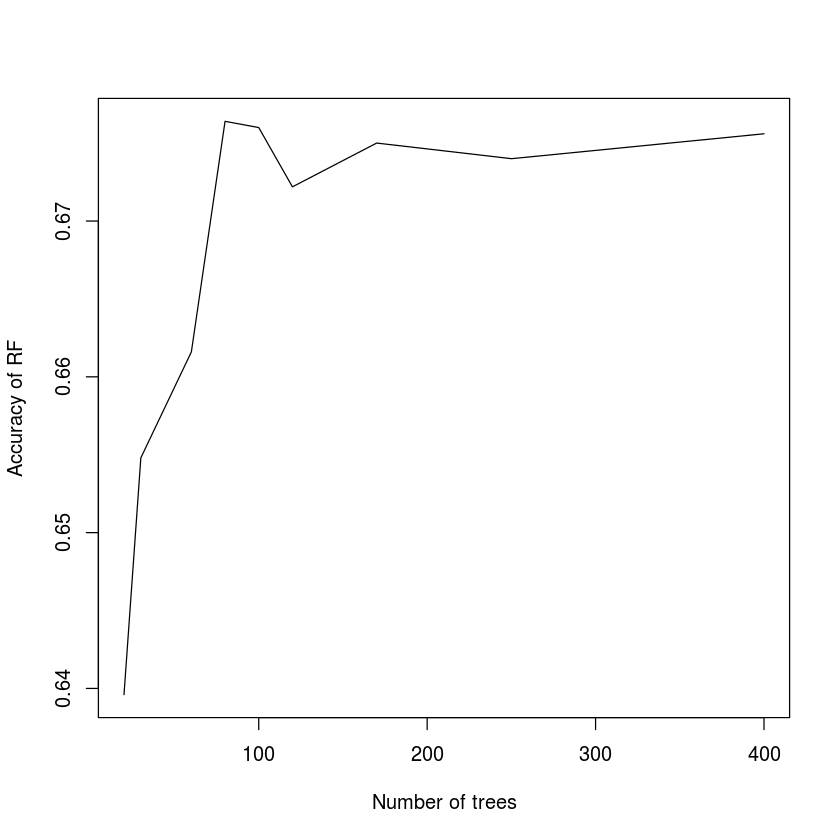

In [146]:
plot(dims,rfFits,type="l",xlab="Number of trees",ylab="Accuracy of RF")

Jak widać z powyższego wykresu, przy osiemdziesięciu drzewach skuteczność na próbce zbioru lasu losowego zaczya się stabilizować i nie ma w tym momencie sensu zwiększach liczby drzew. Powoduje to tylko wzrost złożoności obliczeniowej.

Dla rzeczywistej klasyfikacji, poniżej używam lasu losowego o osiemdziesięciu drzewach i z parametrem mtry ustawionym na 16.

## Klasyfikacja - las losowy

W tym momencie wracam do swojej kroswalidacji (powyższe funkcje nfold_glm i tym podobne), ponieważ cel klasyfikacji jest niestandardowy w tym projekcie.

In [165]:
nfold_rf = function (input_data,n){
    
    nchunk = nrow(input_data)/n
    results = numeric(n)
    
    for (i in 1:n){
        lower = (i-1)*nchunk+1
        upper = i*nchunk
        indices = lower:upper
        #kolumna 1 - etykieta
        tst_y = input_data[indices,1]
        names_tst_x = rownames(input_data[indices,-1])
        #trzeba zapamietac numery wierszy, bo ponizej są tracone:
        tst_x = as.matrix(input_data[indices,-1])
        tr_y =  input_data[-indices,1]
        tr_x =  as.matrix(input_data[-indices,-1])
        g = randomForest(x=tr_x,y=tr_y,ntree = 80, mtry=16)
        predicted_y = predict(g, tst_x, type="prob")[,2]
        names(predicted_y) = names_tst_x
        #zgodnie z zadaną metryką - 20% z najlepszych wyników
        topindices = head(sort(predicted_y,decreasing=TRUE),nfold/5)
        results[i] = mean(input_data[names(topindices),1] == 'klasa +')
    }
    
    return (results)
}

In [166]:
rfy = train_y2
rfx = train_x[,names(pv)] #wyselekcjonowane zmienne
results = nfold_rf (data.frame(y=rfy,rfx),n=10)
print(results)
mean(results)

 [1] 0.829 0.817 0.819 0.816 0.834 0.820 0.818 0.819 0.826 0.823


[1] 0.8221

Wyniki wyglądają dużo lepiej niż dla regresji logistycznej.

# Boosting

## Selekcja zmiennych

Trenuję model xgboost na całym zbiorze i sprawdzam ważność zmiennych

In [60]:
xgx = train_x
xgy = train_y2

In [61]:
xgFitControl = trainControl (method="cv",number = 2) #2fold

xgModel = train(xgx,xgy,
    method = "xgbTree",
    trControl = xgFitControl)

Warning message in xy.coords(x, y, xlabel, ylabel, log):
“NAs introduced by coercion”

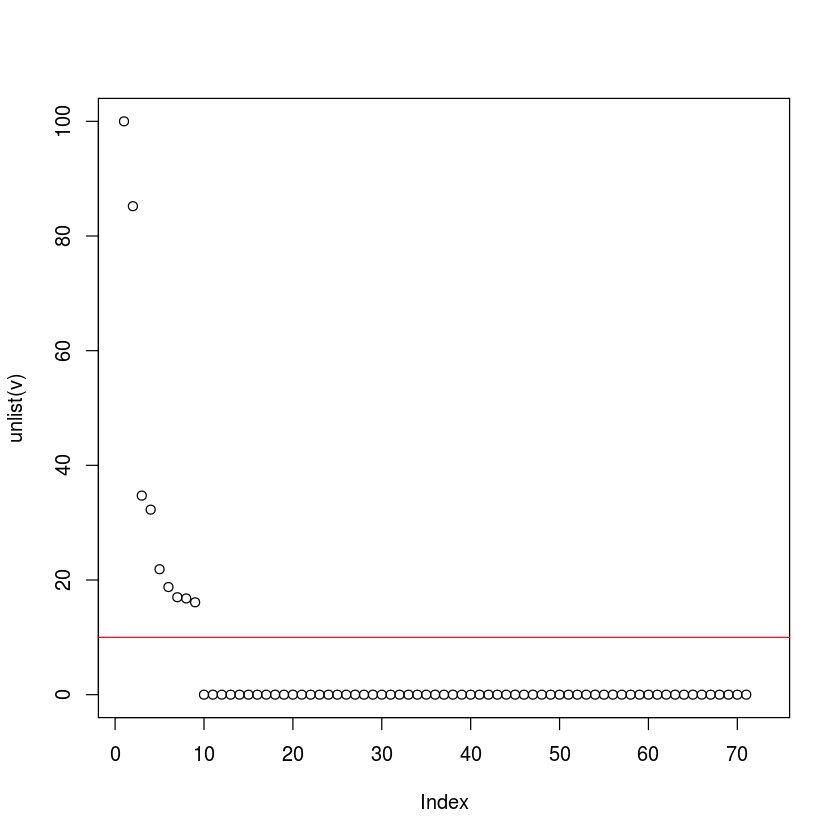

In [286]:
v = varImp(xgModel)
plot(unlist(v))
abline(10,0,col="red")

Dla modelu xgboost widzimy zaskakującą właśność. Jedynie kilka predyktorów ma jakąkolwiek wartość w tego typu klasyfikatorze. Wobec tego, bez wielkich strat mogę znacząco obciąć pulę predyktorów.

In [288]:
(xcoefs = rownames(v$importance)[v$importance>10])

[1] "M1"   "W1"   "E1.A" "P2.A" "U2"   "F2"   "Q1"   "J1"   "T2"

## Tuning parametrów xgboost

Xgboost jest szybsze niż lasy losowe (również z powodu mniejszej liczby uwzględnianych predyktorów), dlatego do znajdywania optymalnych parametrów mogę zastosować większe próbki ze zbioru treningowego.

In [297]:
set.seed(1488)
rnd = sample(1:length(train_y2),10000)
xgx = train_x[rnd,xcoefs]
xgy = train_y2[rnd]
xgFitControl = trainControl (method="cv",number = 5,
  verboseIter = TRUE) #5fold

In [298]:
xgModel = train(xgx,xgy,
    method = "xgbTree", 
    trControl = xgFitControl,
    tuneGrid=expand.grid(
    eta=c(0.1,0.3),
    max_depth=c(0,1,2),
    colsample_bytree=c(0.6,0.8, 0.9),
    subsample=c(0.8,1),
    nrounds=c(50,100,150),
    gamma=c(0.0,0.1),
    min_child_weight=c(0,1,2)
    ),verbose = TRUE)

+ Fold1: eta=0.1, max_depth=0, gamma=0.0, colsample_bytree=0.6, min_child_weight=0, subsample=0.8, nrounds=150 
- Fold1: eta=0.1, max_depth=0, gamma=0.0, colsample_bytree=0.6, min_child_weight=0, subsample=0.8, nrounds=150 
+ Fold1: eta=0.1, max_depth=0, gamma=0.0, colsample_bytree=0.6, min_child_weight=0, subsample=1.0, nrounds=150 
- Fold1: eta=0.1, max_depth=0, gamma=0.0, colsample_bytree=0.6, min_child_weight=0, subsample=1.0, nrounds=150 
+ Fold1: eta=0.1, max_depth=0, gamma=0.0, colsample_bytree=0.6, min_child_weight=1, subsample=0.8, nrounds=150 
- Fold1: eta=0.1, max_depth=0, gamma=0.0, colsample_bytree=0.6, min_child_weight=1, subsample=0.8, nrounds=150 
+ Fold1: eta=0.1, max_depth=0, gamma=0.0, colsample_bytree=0.6, min_child_weight=1, subsample=1.0, nrounds=150 
- Fold1: eta=0.1, max_depth=0, gamma=0.0, colsample_bytree=0.6, min_child_weight=1, subsample=1.0, nrounds=150 
+ Fold1: eta=0.1, max_depth=0, gamma=0.0, colsample_bytree=0.6, min_child_weight=2, subsample=0.8, nroun

Selecting tuning parameters
Fitting nrounds = 150, max_depth = 1, eta = 0.3, gamma = 0.1, colsample_bytree = 0.6, min_child_weight = 1, subsample = 1 on full training set


Trzy najlepsze modele widoczne są poniżej:

In [309]:
filter(xgModel$results,Accuracy>0.722)

eta,max_depth,gamma,colsample_bytree,min_child_weight,subsample,nrounds,Accuracy,Kappa,AccuracySD,KappaSD
0.3,1,0.0,0.8,2,1,150,0.7220997,0.4441855,0.008425810,0.01685938
0.3,1,0.1,0.6,1,1,150,0.7224002,0.4447849,0.008817809,0.01764268
0.3,1,0.1,0.8,0,1,150,0.7223003,0.4445858,0.008774400,0.01755471


Postaram się teraz trochę zawęzić zakresy rozpatrywanych parametrów.

In [311]:
set.seed(1939)
rnd = sample(1:length(train_y2),10000)
xgx = train_x[rnd,xcoefs]
xgy = train_y2[rnd]
xgFitControl = trainControl (method="cv",number = 5) #5fold

xgModel2 = train(xgx,xgy,
    method = "xgbTree", 
    trControl = xgFitControl,
    tuneGrid=expand.grid(
    eta=c(0.2,0.3),
    max_depth=c(1,2,3),
    colsample_bytree=c(0.6,0.8),
    subsample=c(0.8,1),
    nrounds=c(150,200),
    gamma=c(0.0,0.1),
    min_child_weight=c(0,1,2)
    ))

In [317]:
filter(xgModel2$results,Accuracy>0.726)

eta,max_depth,gamma,colsample_bytree,min_child_weight,subsample,nrounds,Accuracy,Kappa,AccuracySD,KappaSD
0.3,1,0.0,0.6,2,0.8,150,0.7262002,0.4524012,0.005866713,0.01173402
0.3,1,0.0,0.8,1,0.8,150,0.7261001,0.4522007,0.006945617,0.01389300
0.3,1,0.1,0.6,0,0.8,150,0.7261000,0.4521988,0.009317112,0.01863325
0.3,1,0.0,0.8,0,0.8,200,0.7265997,0.4531987,0.006640847,0.01328113
0.3,1,0.1,0.6,0,0.8,200,0.7262998,0.4525987,0.008998262,0.01799653
0.3,1,0.1,0.8,1,0.8,200,0.7260994,0.4521996,0.006877638,0.01375557


In [324]:
xgModel2$finalModel$tuneValue

,nrounds,max_depth,eta,gamma,colsample_bytree,min_child_weight,subsample
158,200,1,0.3,0,0.8,0,0.8


Jak można zauważyć, maksymalna głębokość drzew stabilizuje się na stałym poziomie 1. Rozważę jeszcze kolejny zestaw parametrów, jednakże tym razem jedynie dla parametrów różnych w powyższej tabelce, czyli *colsample_bytree*, *gamma*, *min_child_weight* oraz *nrounds*. Dodatkowo sprawdzę na wszelki wypadek ponownie parametr *subsample*.

In [318]:
set.seed(1939)
rnd = sample(1:length(train_y2),10000)
xgx = train_x[rnd,xcoefs]
xgy = train_y2[rnd]
xgFitControl = trainControl (method="cv",number = 5) #5fold

xgModel3 = train(xgx,xgy,
    method = "xgbTree", 
    trControl = xgFitControl,
    tuneGrid=expand.grid(
    eta=c(0.3),
    max_depth=c(1),
    colsample_bytree=c(0.6,0.8),
    subsample=c(0.7,0.8),
    nrounds=c(150,200,250),
    gamma=c(0.0,0.1),
    min_child_weight=c(0,1,2)
    ))

In [329]:
head(xgModel3$results[order(xgModel3$results$Accuracy,decreasing=T),])

,eta,max_depth,gamma,colsample_bytree,min_child_weight,subsample,nrounds,Accuracy,Kappa,AccuracySD,KappaSD
56,0.3,1,0.1,0.8,0,0.7,200,0.7273000,0.4546009,0.007402751,0.01480636
67,0.3,1,0.1,0.8,2,0.7,150,0.7269003,0.4538009,0.006320534,0.01264084
30,0.3,1,0.0,0.8,1,0.8,250,0.7267998,0.4536000,0.005763593,0.01152726
12,0.3,1,0.0,0.6,1,0.8,250,0.7267993,0.4535996,0.008813388,0.01762761
42,0.3,1,0.1,0.6,0,0.8,250,0.7267003,0.4534018,0.009033145,0.01806779
69,0.3,1,0.1,0.8,2,0.7,250,0.7266992,0.4533994,0.005741750,0.01148302


Na tym już zakończę, ponieważ dalsze modyfikacje wartości parametrów zmieniają skuteczność w kroswalidacji bardzo nieznacznie. Wobec tego, za najlepsze, przyjmuję następujące parametry:

In [334]:
xgModel3$finalModel$tuneValue

,nrounds,max_depth,eta,gamma,colsample_bytree,min_child_weight,subsample
56,200,1,0.3,0.1,0.8,0,0.7


## Klasyfikacja xgboost

Dla obliczonych odpowiednich wartości hiperparametrów, wyznaczę profil działania modelu xgBoost w sposób określany poprzednio.

In [63]:
nfold_xg = function (input_data,n, xparams, n_round){
    
    nchunk = nrow(input_data)/n
    results = numeric(n)
    
    for (i in 1:n){
        lower = (i-1)*nchunk+1
        upper = i*nchunk
        indices = lower:upper
        
        #label na koncu ramki:
        names_tst_x = rownames(input_data[indices,-1])
        tst_x = as.matrix(input_data[indices,-1])
        tr_x = as.matrix(input_data[-indices,-1])
        tr_y = as.matrix(input_data[-indices,1])
        
        tr_data=xgb.DMatrix(tr_x,label=tr_y)
        
        g = xgb.train(data=tr_data,params=xparams,nround=n_round,
            objective = "binary:logistic")
        
        predicted_y = predict(g, tst_x)
        names(predicted_y) = names_tst_x
        #dla 5000 chunków biorę 1000 najlepszych score, itd.
        top2000indices = head(sort(predicted_y,decreasing=TRUE),nchunk/5)
        results[i] = mean(input_data[names(top2000indices),1])
    }
    
    return (results)
}

In [65]:
xgx = train_x[,xcoefs]
xgy = train_y
n_round=200
#optymalne parametry
xparams = list(max_depth=1,eta=0.3,gamma=0.1,colsample_bytree=0.8,min_child_weight=0,subsample=0.7)

xgresults = nfold_xg(data.frame(y=xgy,xgx),n=10,xparams=xparams,n_round=n_round)

In [66]:
xgresults
mean(xgresults)

[1] 0.851 0.843 0.841 0.844 0.849 0.849 0.839 0.855 0.838 0.870

[1] 0.8479

Wyniki dla 2fold:

In [67]:
xgresults2 = nfold_xg(data.frame(y=xgy,xgx),n=2,xparams=xparams,n_round=n_round)

In [68]:
xgresults2

[1] 0.8446 0.8486

Wyniki są lepsze niż dla lasu losowego i osiągają 85% przy kroswalidacji.
Postaram się jeszcze, już bardziej z ciekawości, budować znacznie większe drzewa poprzez przestawienie parametru *max_depth*.

In [343]:
xgx = train_x[,xcoefs]
xgy = train_y
n_round=200
#max_width jest teraz równe 10
xparams_m = list(max_depth=10,eta=0.3,gamma=0.1,colsample_bytree=0.8,min_child_weight=0,subsample=0.7)

xgresults_m = nfold_xg(data.frame(y=xgy,xgx),n=10,xparams=xparams_m,n_round=n_round)

In [344]:
xgresults_m

[1] 0.781 0.788 0.784 0.769 0.801 0.778 0.788 0.794 0.780 0.796

Jak widać, zwiększanie limitu na rozmiar drzew powoduje znaczny spadek jakościowy.

W tym miejscu wytrenuję jeszcze model na wszystkich predyktorach, żeby sprawdzić, czy nie podniesie to jakimś cudem skuteczności.

In [345]:
xgx = train_x
xgy = train_y
n_round=200
#optymalne parametry
xparams_all = list(max_depth=1,eta=0.3,gamma=0.1,colsample_bytree=0.8,min_child_weight=0,subsample=0.7)

xgresults_all = nfold_xg(data.frame(y=xgy,xgx),n=10,xparams=xparams_all,n_round=n_round)

In [347]:
xgresults_all
mean(xgresults_all)

[1] 0.850 0.840 0.841 0.851 0.854 0.847 0.830 0.856 0.835 0.865

[1] 0.8469

Patrząc na wyniki modelu na wszystkich zmiennych, można zauważyć jedną z właściwości boostingu - takie modele bardzo trudno przeuczyć. Chociaż powyższy model używa wielu bezsensownych predyktorów, jego skuteczność predykcji w kroswalidacji nie odstaje od modelu z wyselekcjowanymi predyktorami. Nie oznacza to oczywiście, że należy go używać. Ryzyko przeuczenia na zbiorze testowym tego projektu jest zdecydowanie większe od modelu z wybranymi predyktorami. Znacznie większa jest też jego złożoność obliczeniowa (71, a nie 9 predyktorów!)

Wszystko to oznacza, że w chwili obecnej najlepszym kandydatem jest model xgBoost z optymalnymi hiperparametrami.

# Inne klasyfikatory

W poniższych częściach przedstawię działanie innych metod klasyfikacji dla zadanego problemu.

## Drzewo decyzyjne C5.0

Tego typu drzewo jest wynikiem działania algorytmu C5.0 generującego drzewa decyzyjne. 
Algorytm C5.0 jest zmodyfikowaną wersją algorytmu Quinlana C4.5 - jego głównymi ulepszeniami jest to, że jest szybszy i bardziej wydajny pamięciowo.
Algorytm zapewnia dodatkowo wsparcie dla boostingu, wobec czego jest interesującą alternatywą dla xgBoost.

### Selekcja predyktorów i wyznaczanie parametrów

Postępuję tutaj podobnie jak we wcześniejszych klasyfikatorach.

In [18]:
rpx = train_x
rpy = train_y2

In [23]:
rpFitControl = trainControl (method="cv",number = 2) #2fold

rpModel = train(rpx,rpy,
    method = "C5.0",
    trControl = rpFitControl)

W poniższym opisie znajdują się propozycje ustawienia parametrów algorytmu.

In [25]:
rpModel

C5.0 

50000 samples
   71 predictors
    2 classes: 'klasa -', 'klasa +' 

No pre-processing
Resampling: Cross-Validated (2 fold) 
Summary of sample sizes: 25000, 25000 
Resampling results across tuning parameters:

  model  winnow  trials  Accuracy  Kappa    
  rules  FALSE    1      0.68204   0.3640840
  rules  FALSE   10      0.70478   0.4095505
  rules  FALSE   20      0.70862   0.4172328
  rules   TRUE    1      0.67738   0.3547622
  rules   TRUE   10      0.69368   0.3873568
  rules   TRUE   20      0.69272   0.3854343
  tree   FALSE    1      0.67738   0.3547640
  tree   FALSE   10      0.70598   0.4119618
  tree   FALSE   20      0.70712   0.4142404
  tree    TRUE    1      0.67616   0.3523212
  tree    TRUE   10      0.69542   0.3908404
  tree    TRUE   20      0.69428   0.3885600

Accuracy was used to select the optimal model using  the largest value.
The final values used for the model were trials = 20, model = rules and
 winnow = FALSE.

Warning message in xy.coords(x, y, xlabel, ylabel, log):
“NAs introduced by coercion”

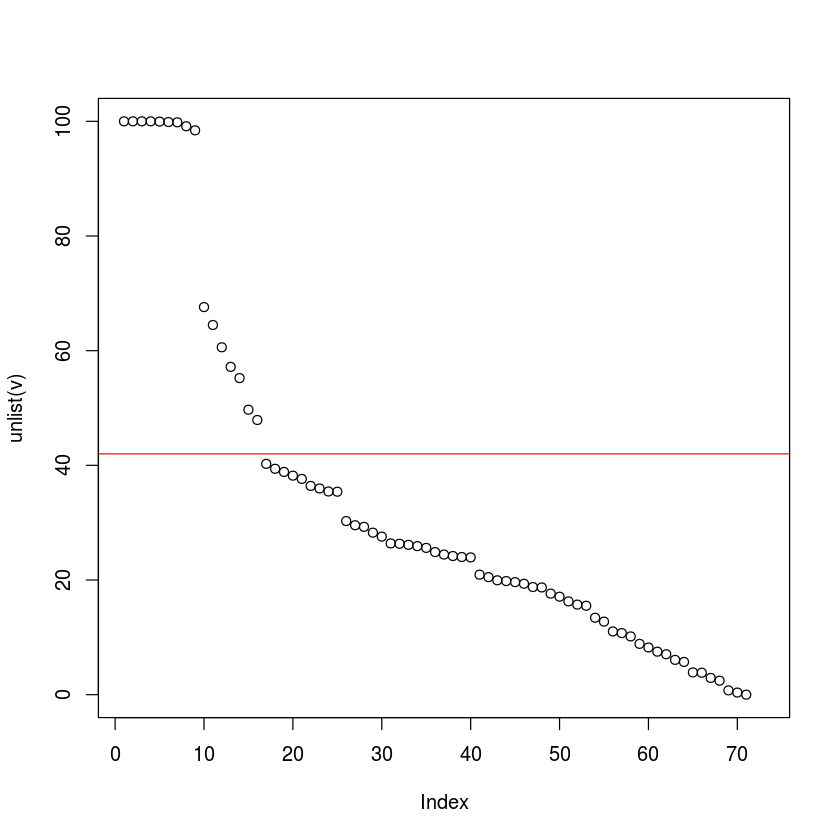

In [28]:
v = varImp(rpModel)
plot(unlist(v))
abline(42,0,col="red")

Obcinam zmienne poniżej czerwonej linii

In [35]:
(rp_coefs = rownames(v$importance)[v$importance>41])

[1] "E1.A" "M1"   "W1"   "P2.A" "T2"   "U2"   "Q1"   "F2"   "J1"   "B1.B"
[11] "T1.A" "I2.B" "O2.B" "T1.C" "L1.C" "P1.A"

### Klasyfikacja

In [40]:
nfold_rp = function (input_data,n){
    
    nchunk = nrow(input_data)/n
    results = numeric(n)

    for (i in 1:n){
        lower = (i-1)*nchunk+1
        upper = i*nchunk
        indices = lower:upper
        #kolumna 1 - etykieta
        tst_y = input_data[indices,1]
        names_tst_x = rownames(input_data[indices,-1])
        #trzeba zapamietac numery wierszy, bo ponizej są tracone:
        tst_x = as.matrix(input_data[indices,-1])
        tr_y =  input_data[-indices,1]
        tr_x =  as.matrix(input_data[-indices,-1])
        g = C5.0(tr_x,tr_y,trials=20,rules=TRUE,control = C5.0Control(winnow = FALSE))#optymalne parametry
        predicted_y = predict(g, tst_x, type="prob")[,2]
        names(predicted_y) = names_tst_x
        #dla 5000 predykcji (10fold), sprawdzam top 1000 (20%) scores
        topindices = head(sort(predicted_y,decreasing=TRUE),nchunk/5)
        results[i] = mean(input_data[names(topindices),1] == 'klasa +')
    }
    
    return (results)
}

In [42]:
rp_x = train_x[,rp_coefs]
rp_y = train_y2
rp_results = nfold_rp(data.frame(y=rp_y,rp_x),n=10)

In [43]:
rp_results
mean(rp_results)

[1] 0.845 0.846 0.847 0.837 0.846 0.837 0.827 0.835 0.838 0.850

[1] 0.8408

Drzewo decyzyjne C5.0 daje wyniki lepsze niż las losowy i nieznacznie gorsze od xgBoost.

## Naiwny klasyfikator Bayesa

Naiwny klasyfikator Bayesa to klasyfikator, który zawsze warto przetestować, dlatego też poniżej wyznaczę jego efektywność dla naszego problemu.

### Selekcja zmiennych i wyznaczanie parametrów

In [63]:
nbx = train_x
nby = train_y2

In [64]:
nbFitControl = trainControl (method="cv",number = 2) #2fold

nbModel = train(nbx,nby,
    method = "naive_bayes",
    trControl = nbFitControl)

Poniżej znajdują się propozycje ustawienia parametrów dla tego modelu.

In [65]:
nbModel

Naive Bayes 

50000 samples
   71 predictors
    2 classes: 'klasa -', 'klasa +' 

No pre-processing
Resampling: Cross-Validated (2 fold) 
Summary of sample sizes: 25000, 25000 
Resampling results across tuning parameters:

  usekernel  Accuracy  Kappa    
  FALSE      0.64750   0.2950112
   TRUE      0.71098   0.4219751

Tuning parameter 'fL' was held constant at a value of 0
Tuning
 parameter 'adjust' was held constant at a value of 1
Accuracy was used to select the optimal model using  the largest value.
The final values used for the model were fL = 0, usekernel = TRUE and adjust
 = 1.

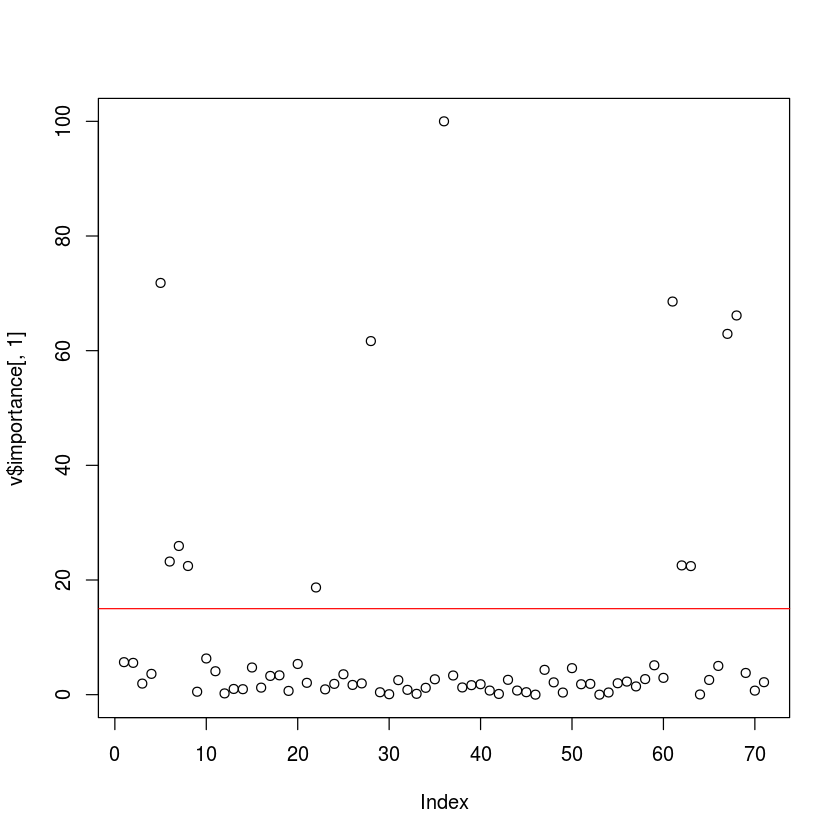

In [74]:
v = varImp(nbModel)
plot(v$importance[,1])
abline(15,0,col="red")

Wybieram predyktory o ważności większej niż 40.

In [75]:
(nb_coefs = rownames(v$importance)[v$importance[,1]>18])

[1] "E1.A" "E1.B" "E1.C" "E1.D" "M1"   "Q1"   "W1"   "P2.A" "P2.B" "P2.C"
[11] "T2"   "U2"

### Klasyfikacja

In [78]:
nfold_nb = function (input_data,n){
    
    nchunk = nrow(input_data)/n
    results = numeric(n)

    for (i in 1:n){
        lower = (i-1)*nchunk+1
        upper = i*nchunk
        indices = lower:upper
        #kolumna 1 - etykieta
        tst_y = input_data[indices,1]
        names_tst_x = rownames(input_data[indices,-1])
        #trzeba zapamietac numery wierszy, bo ponizej są tracone:
        tst_x = as.matrix(input_data[indices,-1])
        tr_y =  input_data[-indices,1]
        tr_x =  as.matrix(input_data[-indices,-1])
        g = naive_bayes(tr_x,tr_y,useKernel=TRUE)#optymalne parametry
        predicted_y = predict(g, tst_x, type="prob")[,2]
        names(predicted_y) = names_tst_x
        #dla 5000 predykcji (10fold), sprawdzam top 1000 (20%) scores
        topindices = head(sort(predicted_y,decreasing=TRUE),nchunk/5)
        results[i] = mean(input_data[names(topindices),1] == 'klasa +')
    }
    
    return (results)
}

In [79]:
nbx = train_x[,nb_coefs]
nby = train_y2

nb_results = nfold_nb(data.frame(y=nby,nbx),n=10)

In [80]:
nb_results
mean(nb_results)

[1] 0.774 0.763 0.770 0.756 0.781 0.759 0.767 0.781 0.759 0.782

[1] 0.7692

Naiwny klasyfikator Bayesa okazuje się gorszy niż jakiekolwiek drzewa decyzyjne poruszone w tym raporcie, jednakże jest, co ciekawe, lepszy niż regresja logistyczna.